In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import os
import re

plt.style.use([hep.style.CMS, hep.style.firamath])

_outdir='/eos/user/p/psilva/www/EXO-19-009/paper_fr'
os.system(f'mkdir -p {_outdir}')

0

In [2]:
df=pd.read_hdf('/eos/user/p/psilva/data/ppszx/limits_6Jan2022/acceptance_histos.h5',key='data')
df.rename(columns={
                    0:'mass',1:'channel',2:'proton_cat',3:'xangle',4:'era',
                    5:'outfid_gen',6:'outfid_cms',7:'outfid_cms_pps',
                    8:'fid_gen',9:'fid_cms',10:'fid_cms_pps',
                  },inplace=True,)

mask=(df['proton_cat']=='')
for x in ['fid_gen','fid_cms','outfid_gen','outfid_cms']:
    df.loc[mask,x]=df.loc[mask,x]/16
df.head()

mass channel proton_cat  xangle      era  outfid_gen  outfid_cms  \
0  1000      ee                120  postTS2    0.066716    0.041305   
1  1000      ee         -1     120  postTS2    0.944934    0.584954   
2  1000      ee          1     120  postTS2    0.069878    0.043319   
3  1000      ee          2     120  postTS2    0.007352    0.004561   
4  1000      ee          3     120  postTS2    0.031134    0.019284   

   outfid_cms_pps   fid_gen   fid_cms  fid_cms_pps  
0        0.029265  0.054933  0.033964     0.019066  
1        0.025104  0.607188  0.375415     0.009703  
2        0.001776  0.189133  0.116924     0.004717  
3        0.000219  0.035048  0.021674     0.000679  
4        0.001381  0.032097  0.019846     0.002524

In [3]:
def integrateCounts(level='cms_pps',xangle_list=None,protoncat_list=None,era_list=None):

    
    df_integ=[]
    
    mask=(df['proton_cat']!='') & (df['proton_cat']!='-1') 
    if protoncat_list:
        for p in protoncat_list: mask &= (df['proton_cat']==p)
    if xangle_list:
        for x in xangle_list: mask &= (df['xangle']==x)
    if era_list:
        for e in era_list: mask &= (df['era']==e)
            
    for key,group in df[mask].groupby(['mass','channel']):

        fidcounts=group[f'fid_{level}'].sum()
        outfidcounts=group[f'outfid_{level}'].sum()
    
        genmask=(df['proton_cat']=='') & (df['mass']==key[0]) & (df['channel']==key[1])
        gencounts = df.loc[genmask][['fid_gen','outfid_gen']].sum()
        
        df_integ.append( [key[0],key[1],gencounts['fid_gen'],gencounts['outfid_gen'],fidcounts,outfidcounts] )
    
    df_integ=pd.DataFrame(df_integ,columns=['mass','channel','fid_gen','outfid_gen','fid_sel','outfid_sel'])
    return df_integ


df_inc = integrateCounts()
df_inc_preTS2 = integrateCounts(era_list=['preTS2'])
df_inc_postTS2 = integrateCounts(era_list=['postTS2'])

df_xangle={}
for xangle in [120,130,140,150]:
    df_xangle[xangle]=integrateCounts(xangle_list=[xangle])
df_p={}
df_p_preTS2={}
df_p_postTS2={}
for p in ['1','2','3','4']:
    df_p[p]=integrateCounts(protoncat_list=[p])    
    df_p_preTS2[p]=integrateCounts(protoncat_list=[p],era_list=['preTS2'])    
    df_p_postTS2[p]=integrateCounts(protoncat_list=[p],era_list=['postTS2'])    

df_e={}
for e in ['preTS2','postTS2']:
    df_e[e]=integrateCounts(era_list=[e])
df_inc.head()

mass channel   fid_gen  outfid_gen   fid_sel  outfid_sel
0   600       a  0.578573    0.399424  0.049914    0.012196
1   600      ee  0.365347    0.298665  0.048683    0.014511
2   600      mm  0.365347    0.298665  0.059388    0.017676
3   620       a  0.591398    0.386594  0.052297    0.011470
4   620      ee  0.376416    0.289023  0.051330    0.013579

In [4]:
df_p['1']['aeff']=df_p['1']['fid_sel']/df_p['1']['fid_gen']
df_p['1'][df_p['1']['mass']==1400][['channel','aeff']]

channel      aeff
120       a  0.033226
121      ee  0.053100
122      mm  0.064700

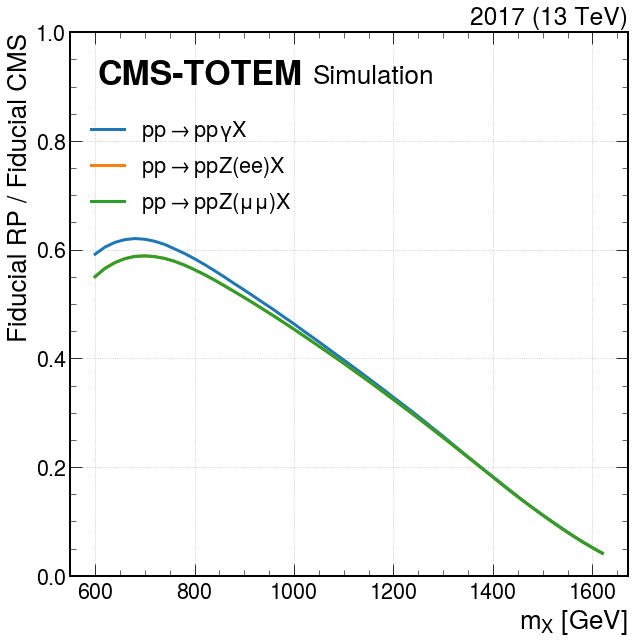

In [5]:
ch_titles={'ee':r'$pp\rightarrow ppZ(ee)X$','mm':r'$pp\rightarrow ppZ(\mu\mu)X$','a':r'$pp\rightarrow pp\gamma X$'}
for ch,group in df_inc.groupby('channel'):
    plt.plot(group['mass'],group['fid_gen']/(group['fid_gen']+group['outfid_gen']),label=ch_titles[ch],linewidth=3)
plt.grid()
plt.legend(title='\n', loc='upper left')
plt.xlabel(r'$m_{X}$ [GeV]')
plt.ylabel('Fiducial RP / Fiducial CMS')
plt.ylim(0,1.0)
hep.cms.label_base.exp_label(exp='CMS-TOTEM',loc=1,rlabel='2017 (13 TeV)')
plt.savefig(os.path.join(_outdir,'fidsig.pdf'))
#plt.show()

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['channel', 'mx', 'acceff'], dtype='object')]

  pytables.to_hdf(


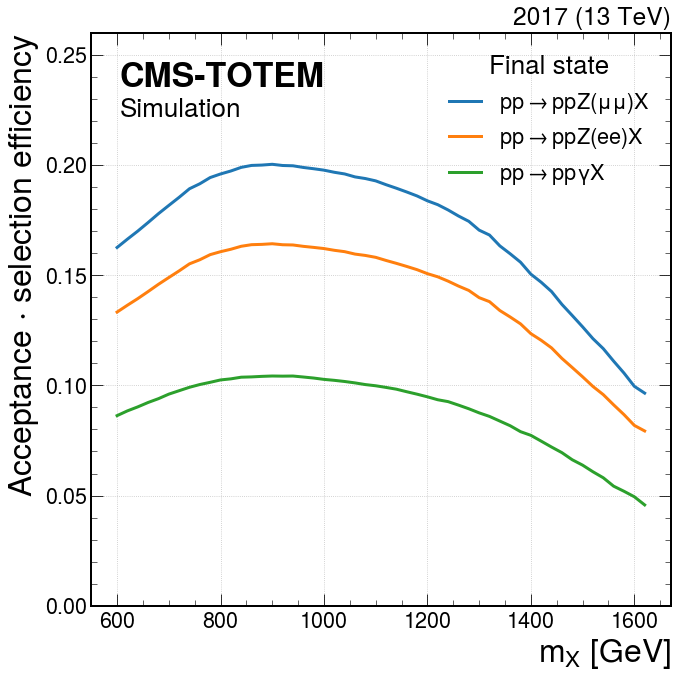

In [6]:
fig,ax=plt.subplots()
fig_data=[]
for ch in ['mm','ee','a']:
    mask=(df_inc['channel']==ch)
    x,y=df_inc[mask]['mass'].values,(df_inc[mask]['fid_sel']/df_inc[mask]['fid_gen']).values
    fig_data.append([ch_titles[ch],x,y])
    ax.plot(x,y,linewidth=3,label=ch_titles[ch])
ax.legend(title='Final state',loc='upper right')
ax.grid()
ax.set_xlabel(r'$m_{X}$ [GeV]',fontsize=32)
ax.set_ylabel(r'Acceptance $\cdot$ selection efficiency',fontsize=32)
ax.set_ylim(0,0.26)
#hep.cms.label(data=True,year=2017)
#hep.cms.label_base.exp_label(exp='CMS-TOTEM')
hep.cms.label_base.exp_label(exp='CMS-TOTEM',loc=2,rlabel='2017 (13 TeV)')
fig.tight_layout()
#plt.show()
plt.savefig(os.path.join(_outdir,'acceff_finalstate.pdf'))

fig_df=pd.DataFrame(fig_data,columns=['channel','mx','acceff'])
fig_df.to_hdf(os.path.join(_outdir,'acceff_finalstate.h5'),mode='w',key='fig')

/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['channel', 'categ', 'mx', 'acceff'], dtype='object')]

  pytables.to_hdf(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['channel', 'categ', 'mx', 'acceff'], dtype='object')]

  pytables.to_hdf(
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/pandas/core/generic.py:2605: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly

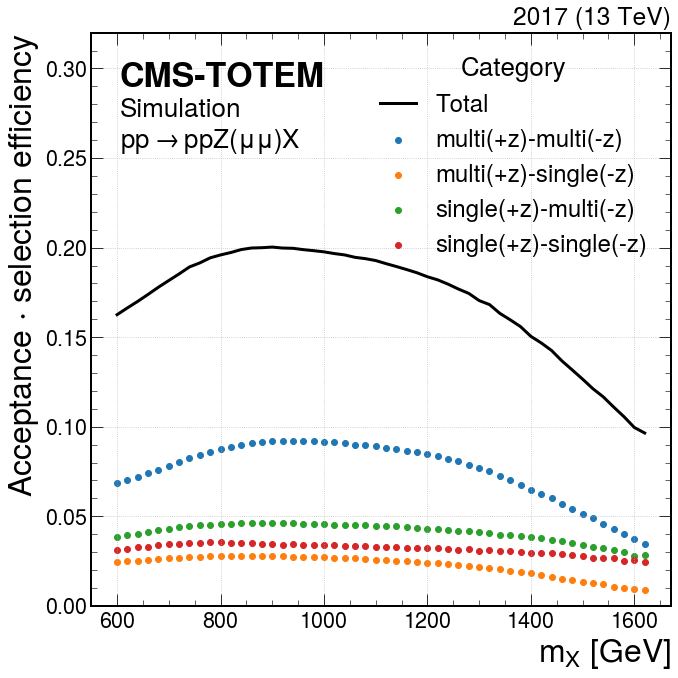

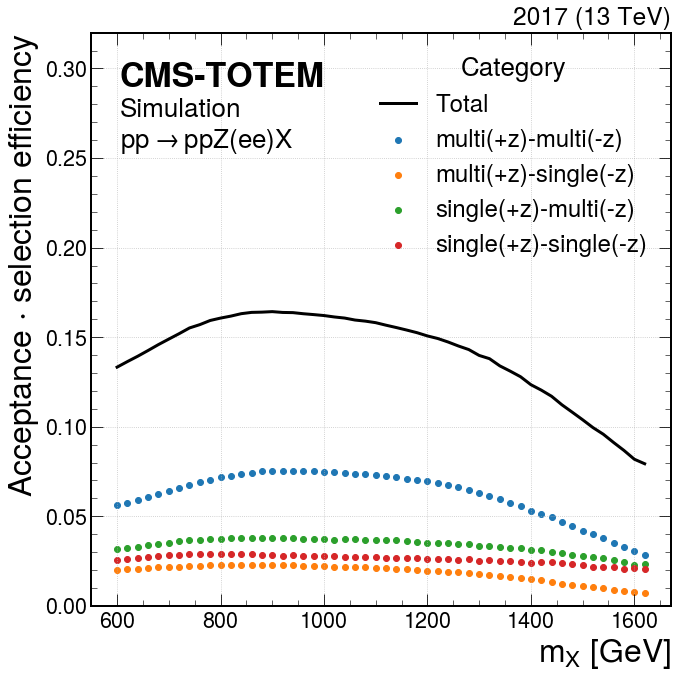

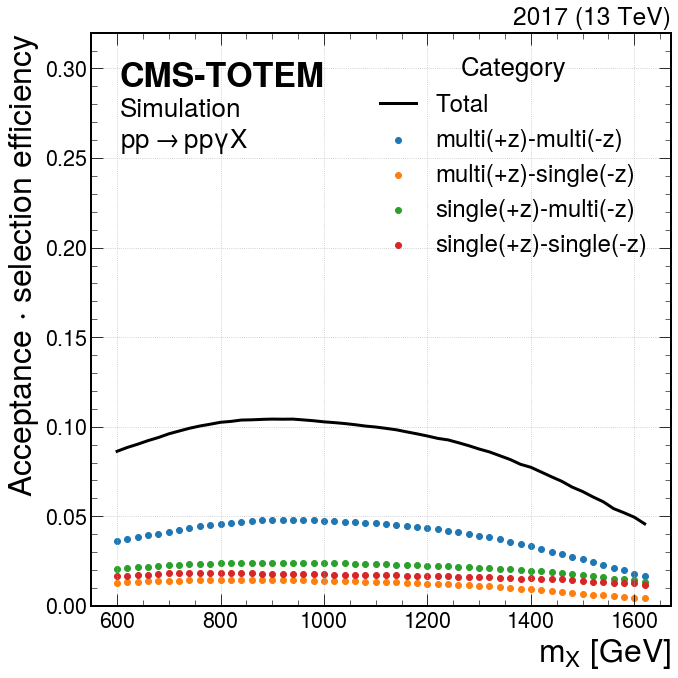

In [12]:
def showContributionsToEfficiency(df_inc,df_diff,plist,plabels,title,pname):

    for ch in ['mm','ee','a']:

        fig_data=[]
        fig,ax=plt.subplots()
        
        mask=(df_inc['channel']==ch)
        x,y=df_inc[mask]['mass'].values,(df_inc[mask]['fid_sel']/df_inc[mask]['fid_gen']).values
        ax.plot(x,y,color='k',linewidth=3,label='Total')
        fig_data.append([ch_titles[ch],'Total',x,y])

        for p in plist:
            mask=(df_diff[p]['channel']==ch)
            x,y=df_diff[p][mask]['mass'].values,(df_diff[p][mask]['fid_sel']/df_diff[p][mask]['fid_gen']).values
            ax.scatter(x,y,label=plabels[p])
            fig_data.append([ch_titles[ch],plabels[p],x,y])
            
        ax.legend(title=title,loc='upper right',fontsize=24)
        ax.text(0.05,0.8,ch_titles[ch],transform=ax.transAxes)
        ax.grid()
        ax.set_xlabel(r'$m_{X}$ [GeV]',fontsize=32)
        ax.set_ylabel(r'Acceptance $\cdot$ selection efficiency',fontsize=32)
        ax.set_ylim(0,0.32)
        hep.cms.label_base.exp_label(exp='CMS-TOTEM',loc=2,rlabel='2017 (13 TeV)')
        fig.tight_layout()
        #plt.show()
        plt.savefig(f'{_outdir}/acceff_{ch}_{pname}.pdf')
        
        fig_df=pd.DataFrame(fig_data,columns=['channel','categ','mx','acceff'])
        fig_df.to_hdf(f'{_outdir}/acceff_{ch}_{pname}.h5',mode='w',key='fig')
        
#xangle_dict=dict([(x,r'${}\mu rad$'.format(x)) for x in [120,130,140,150]])
#showContributionsToEfficiency(df_inc,df_xangle,[120,130,140,150],xangle_dict,'Beam crossing angle',pname='xangle')

proton_reco_dict={'1':'multi(+z)-multi(-z)','2':'multi(+z)-single(-z)','3':'single(+z)-multi(-z)','4':'single(+z)-single(-z)'}
showContributionsToEfficiency(df_inc,df_p,['1','2','3','4'],proton_reco_dict,'Category','protoncategory')

#showContributionsToEfficiency(df_inc_preTS2,df_p_preTS2,['1','2','3','4'],proton_reco_dict,'Category (pre-TS2)',pname='protoncategory_preTS2')
#showContributionsToEfficiency(df_inc_postTS2,df_p_postTS2,['1','2','3','4'],proton_reco_dict,'Category (post-TS2)',pname='protoncategory_postTS2')

#era_dict={'preTS2':'pre-TS2','postTS2':'post-TS2'}
#showContributionsToEfficiency(df_inc,df_e,['preTS2','postTS2'],era_dict,'Era',pname='era')